In [1]:
import MDAnalysis
import itertools
import time
import os
import glob
import sys
import numpy as np
import subprocess
from DEERpredict.PREPrediction import PREPrediction
from argparse import ArgumentParser
import psutil
import ray
from jinja2 import Template
import logging
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import minimize_scalar, least_squares

In [2]:
u = MDAnalysis.Universe('ACBP/1nti.pdb')
u.select_atoms('name {} and protein'.format('N'))

<AtomGroup with 86 atoms>

In [10]:
def load_expPREs(path,labels):
    data = {}
    for label in labels:
        resnums, data[label] = np.loadtxt(path+'/exp{:d}.dat'.format(label),unpack=True)
    df = pd.DataFrame(data,index=resnums)
    df.rename_axis('residue', inplace=True)
    df.rename_axis('label', axis='columns',inplace=True)
    return resnums, df

def load_calcPREs(path,labels):
    data = {}
    for label in labels:
        resnums, data[label], _ = np.loadtxt(path+'/res-{:d}.dat'.format(label),unpack=True)
    df = pd.DataFrame(data, index=resnums)
    df.rename_axis('residue', inplace=True)
    df.rename_axis('label', axis='columns',inplace=True)
    return resnums, df

def calcIratio(tau_c,args):
    label, tau_t, r_2, Cbeta = args
    u = MDAnalysis.Universe('ACBP/1nti.pdb')
    PRE = PREPrediction(u, label, output_prefix = 'ACBP/calcPREs/res', weights = False,
          load_file = False, tau_t = tau_t*1e-9, log_file = 'ACBP/calcPREs/log', delay = 10e-3,
          tau_c = tau_c*1e-09, k = 1.23e16, r_2 = r_2, temperature = 298, Z_cutoff = 0.2, Cbeta = Cbeta,
          atom_selection = 'H', wh = 750)
    PRE.run()
    calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
    chi2 = np.power(calcPREs - expPREs[label],2).sum() / expPREs[label].count()
    return chi2

def calcIratioDynRange(tau_c,args):
    label, tau_t, r_2, Cbeta = args
    u = MDAnalysis.Universe('ACBP/1nti.pdb')
    PRE = PREPrediction(u, label, output_prefix = 'ACBP/calcPREs/res', weights = False,
          load_file = False, tau_t = tau_t*1e-9, log_file = 'ACBP/calcPREs/log', delay = 10e-3,
          tau_c = tau_c*1e-09, k = 1.23e16, r_2 = r_2, temperature = 298, Z_cutoff = 0.2, Cbeta = Cbeta,
          atom_selection = 'H', wh = 750)
    PRE.run()
    calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
    ndx = expPREs[(expPREs[label]>.1)&(expPREs[label]<.9)].index.astype(int)
    chi2 = np.power(calcPREs[ndx-1] - expPREs.loc[ndx,label],2).sum() / expPREs.loc[ndx,label].count()
    return chi2

In [8]:
labels = [17,36,46,65,86]
resnums, expPREs = load_expPREs('ACBP/expPREs',labels)

In [5]:
%%timeit
calcIratio(2,[17, 12.6, False])

498 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


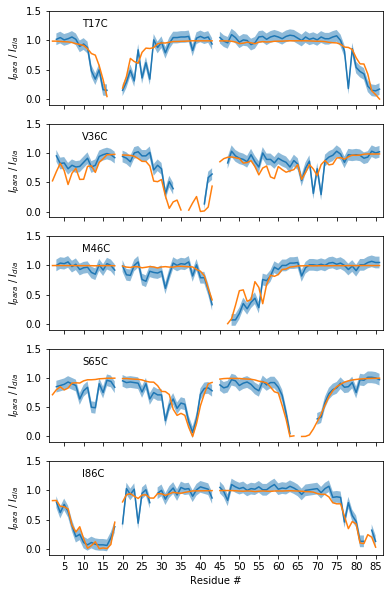

In [12]:
fig, axes = plt.subplots(len(labels), 1, sharex=True, sharey=False, figsize=(6,10))

for ax,label,res in zip(axes.flatten(),labels,'TVMSI'):
    ax.plot(resnums, expPREs[label])
    ax.fill_between(resnums, expPREs[label]-.1, expPREs[label]+.1,alpha=.5)
    calcIratio(2,[label, 12.6, False])
    calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
    ax.plot(resnums, calcPREs)
    ax.annotate(res+str(label)+'C',xy=(.1,.83),xycoords='axes fraction')
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.5)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,5)[1:])
axes.flatten()[-1].set_xlabel('Residue #')
plt.savefig('ACBP/figs/fig4.pdf')

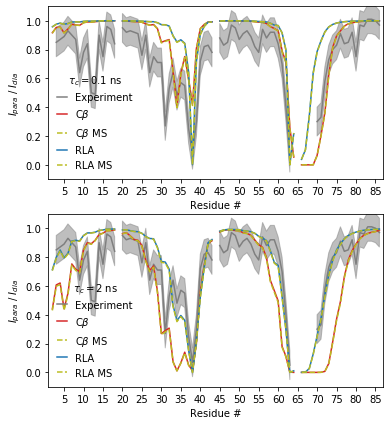

In [16]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6,7))

label=65

ax1.plot(resnums, expPREs[label], color=plt.cm.tab10(7), label='Experiment')
ax1.fill_between(resnums, expPREs[label]-.1, expPREs[label]+.1,alpha=.5, color=plt.cm.tab10(7))
calcIratio(.1,[label, 0.1, 12.6, True])
calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(3), label=r'C$\beta$')

calcPREs = np.loadtxt('/Users/giulio/cg-idps/DEER_MS/cb_compare/cmp_65/PRE_1nti_0.1-65_CB.dat')[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ MS')

calcIratio(.1,[label, 0.1, 12.6, False])
calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(0), label='RLA')

calcPREs = np.loadtxt('/Users/giulio/cg-idps/DEER_MS/cb_compare/cmp_65/PRE_1nti_0.1-65.dat')[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA MS')

ax1.legend(frameon=False,title=r'$\tau_c=0.1$ ns',handlelength=1)

ax2.plot(resnums, expPREs[label], color=plt.cm.tab10(7), label='Experiment')
ax2.fill_between(resnums, expPREs[label]-.1, expPREs[label]+.1,alpha=.5, color=plt.cm.tab10(7))
calcIratio(2,[label, 0.5, 12.6, True])
calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(3), label=r'C$\beta$')

calcPREs = np.loadtxt('/Users/giulio/cg-idps/DEER_MS/cb_compare/cmp_65/PRE_1nti_2-65_CB.dat')[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ MS')

calcIratio(2,[label, 0.5, 12.6, False])
calcPREs = np.loadtxt('ACBP/calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(0), label='RLA')

calcPREs = np.loadtxt('/Users/giulio/cg-idps/DEER_MS/cb_compare/cmp_65/PRE_1nti_2-65.dat')[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA MS')

ax2.legend(frameon=False,title=r'$\tau_c=2$ ns',handlelength=1)

for ax in [ax1,ax2]:
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.1)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,5)[1:])
    ax.set_xlabel('Residue #')
plt.savefig('ACBP/figs/fig5.pdf')
plt.show()

In [ ]:
for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratio(tau_c, [label, 12.6,  False]))
    np.savetxt('ACBP/chi2tau_c/chi2RLA{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratioDynRange(tau_c, [label, 12.6,  False]))
    np.savetxt('ACBP/chi2tau_c/chi2RLADynRange{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratio(tau_c, [label, 12.6,  True]))
    np.savetxt('ACBP/chi2tau_c/chi2Cbeta{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratioDynRange(tau_c, [label, 12.6,  True]))
    np.savetxt('ACBP/chi2tau_c/chi2CbetaDynRange{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

In [47]:
for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratio(2, [label, r_2,  False]))
    np.savetxt('ACBP/chi2r_2/chi2RLA{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratioDynRange(2, [label, r_2,  False]))
    np.savetxt('ACBP/chi2r_2/chi2RLADynRange{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratio(2, [label, r_2,  True]))
    np.savetxt('ACBP/chi2r_2/chi2Cbeta{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratioDynRange(2, [label, r_2,  True]))
    np.savetxt('ACBP/chi2r_2/chi2CbetaDynRange{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

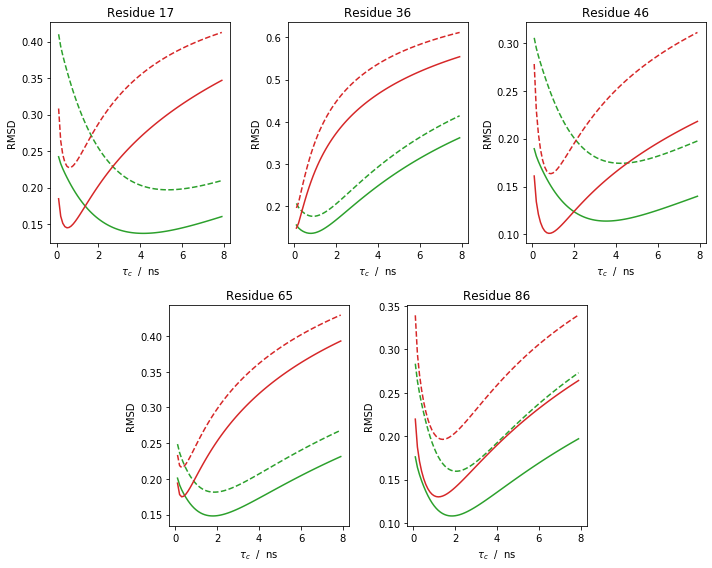

In [14]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plt.figure(figsize=(10,8)))
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
for ax,label in zip(axes,labels):
    tau_c,chi2 = np.loadtxt('ACBP/chi2tau_c/chi2RLA{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(2), label='RLA')
    tau_c,chi2 = np.loadtxt('ACBP/chi2tau_c/chi2RLADynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(2), ls='--', label='RLA dyn. range')
    tau_c,chi2 = np.loadtxt('ACBP/chi2tau_c/chi2Cbeta{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(3), label=r'C$\beta$')
    tau_c,chi2 = np.loadtxt('ACBP/chi2tau_c/chi2CbetaDynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(3), ls='--', label=r'C$\beta$ dyn. range')
    ax.set_title('Residue {:d}'.format(label))
    ax.set_xlabel(r'$\tau_c$  /  ns')
    ax.set_ylabel(r'RMSD')
plt.tight_layout(w_pad=1.5)
plt.savefig('ACBP/figs/figS2.pdf')

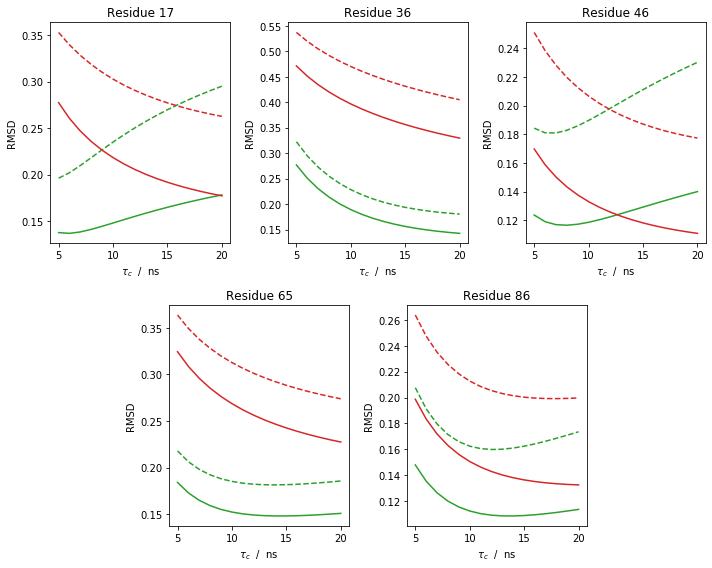

In [15]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plt.figure(figsize=(10,8)))
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
for ax,label in zip(axes,labels):
    r_2,chi2 = np.loadtxt('ACBP/chi2r_2/chi2RLA{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(2), label='RLA')
    r_2,chi2 = np.loadtxt('ACBP/chi2r_2/chi2RLADynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(2), ls='--', label='RLA dyn. range')
    r_2,chi2 = np.loadtxt('ACBP/chi2r_2/chi2Cbeta{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(3), label=r'C$\beta$')
    r_2,chi2 = np.loadtxt('ACBP/chi2r_2/chi2CbetaDynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(3), ls='--', label=r'C$\beta$ dyn. range')
    ax.set_title('Residue {:d}'.format(label))
    ax.set_xlabel(r'$\tau_c$  /  ns')
    ax.set_ylabel(r'RMSD')
plt.tight_layout(w_pad=1.5)
plt.savefig('ACBP/figs/figS3.pdf')

In [130]:
for label in labels:    
    res = minimize_scalar(calcIratioDynRange, args=[label, 12.6, False], bounds=(1, 3), method='bounded')
    print(res.x)

1.8082442276647765
1.0000040198635443
2.999996009801031
1.4763451759526083
1.0000040198635443
